# Preamble

In [6]:
##############################

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec


import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')
import subphase_calc_functions as subphase_calc
import phase_calc_functions as phase_calc
import subphase_plot_functions as subphase_plot
import trend_functions
import trend_plot_functions as trend_plot
import load_dataset as load

# Readin

In [7]:
rmm = load.load_rmm()
rmm

<xarray.Dataset>
Dimensions:    (time: 16714)
Coordinates:
  * time       (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2020-03-04
Data variables:
    RMM1       (time) float64 1.634 1.603 1.516 1.51 ... 0.8542 1.097 1.306 1.52
    RMM2       (time) float64 1.203 1.015 1.086 1.036 ... -1.402 -1.363 -0.9508
    phase      (time) int64 5 5 5 5 5 6 6 6 6 7 6 5 ... 7 7 8 8 1 2 4 4 3 3 3 4
    amplitude  (time) float64 2.029 1.897 1.865 1.831 ... 1.498 1.78 1.887 1.793

In [8]:
# This version of AWAP is just for the north, wet-season and for raindays
awap = load.load_awap()

# Calculations

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Splitting </font></center></div>

In [9]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm)

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Above_q </font></center></div>

In [10]:
subphase_calc = reload(subphase_calc)
# Both of the files have to be moved to be in the wet season, 
q = 90
above_q = subphase_calc.find_events_above_q(awap.precip, awap_split.precip, q)

In [11]:
above_q

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, time: 6469)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * time     (time) datetime64[ns] 1974-10-01 1974-10-02 ... 2017-03-31
    month    (time) int64 10 10 10 10 10 10 10 10 10 10 ... 3 3 3 3 3 3 3 3 3 3
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Wet-season Recalibrate </font></center></div>

Making each year the data that is just for one wet season e.g moving the start of the wet-season to the next year

In [12]:
trend_function = reload(trend_functions)
above_q_ws = trend_functions.wet_season_year(above_q)

In [13]:
above_q_ws

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, time: 6469)
Coordinates:
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2018-12-31
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [14]:
all_phase = above_q_ws.sum(dim = 'phase')
all_phase['phase'] = ['all']
all_phase

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 1, time: 6469)
Coordinates:
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2018-12-31
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * phase    (phase) <U3 'all'
Data variables:
    precip   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [15]:
above_q_ws_all = xr.concat([above_q_ws, all_phase], dim = 'phase')

In [16]:
above_q_ws_all

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 5, time: 6469)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2018-12-31
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * phase    (phase) object 'enhanced' 'suppressed' ... 'inactive' 'all'
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Count Calculation </font></center></div>

In [17]:
above_q_ws_count = above_q_ws.resample(time = 'y').count(dim = 'time')


# The trend function that I created used year not time
above_q_ws_count = above_q_ws_count.rename({'time':'year'})

# Otherwise it contians month and day which are superflous
above_q_ws_count['year'] = above_q_ws_count.year.dt.year.values

#Getting rid of the incomplete start and end points
above_q_ws_count = above_q_ws_count.sel(year = slice(1975,2017)) 
above_q_ws_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (year, phase, lat, lon) int64 0 2 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0

# Plotting

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Trend Calculation </font></center></div>

Non-Normalised

In [18]:
trend_function = reload(trend_functions)
trend_count, trend_count_sig,trend_count_percent, trend_count_percent_sig = \
            trend_function.return_alltrendinfo_custom(above_q_ws_count.precip, normalise = 0)

data has been normalised
trend has been calculated
trend has been converted to percent
significant points habe been found
function is complete


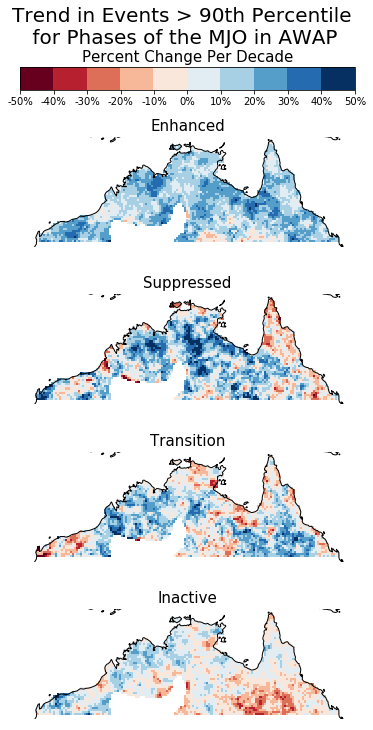

In [19]:
trend_plot = reload(trend_plot)
trend_plot.trend_plots(trend_count_percent.trend,
                        titlepiece = 'Events > 90th Percentile\n', datasource = 'AWAP',
                       colorbar_title = 'Percent Change Per Decade', 
                        vmax = 50)

In [20]:
trend_function= reload(trend_functions)
trend_count_norm , trend_count_sig_norm ,trend_count_percent_norm , trend_count_percent_sig_norm  = \
            trend_function.return_alltrendinfo_custom(above_q_ws_count.precip, normalise = 1)

AttributeError: module 'subphase_calc_functions' has no attribute 'load_rmm'

In [ ]:
trend_count_percent_sig_norm

In [ ]:
trend_plot = reload(trend_plot)
trend_plot.trend_plots(trend_count_percent_norm.trend,
                        titlepiece = 'Events > 90th Percentile\n', datasource = 'AWAP',
                       colorbar_title = 'Percent Change Per Decade', 
                        vmax = 50)

# Number of Days in Each Phase

In [ ]:
trend_functions = reload(trend_functions)
subphase_count = trend_functions.count_in_rmm_subphsae(rmm)

In [ ]:
subphase_count

In [ ]:
fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(2,2)


for i,phase in enumerate(subphase_count.phase.values):
    data = subphase_count.sel(phase = phase)
    ax = fig.add_subplot(gs[i])
    ax.plot(data.number)
    ax.set_title(phase)